# Applied Time Series

## Exercise 1.1

<div class="alert alert-block alert-info">
<b></b> 

1. download data
2. data pre-treatment   
3. Box-Jerkins #1: identification
4. Box-Jerkins #2: estimation
5. Box-Jerkins #3: diagnostics
6. Forecasts 
7. Forecast evaluation
8. Extra - seasonality     
</div>

## 1. Download data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
country='IT'

dataEU_GDP=pd.read_json(f'http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/namq_10_gdp?geo={country}&na_item=B1GQ&s_adj=NSA&unit=CP_MEUR',typ='series',orient='table',numpy=True) 
x=[]
for i in range((sorted(int(v) for v in dataEU_GDP['value'].keys())[0]),1+(sorted((int(v) for v in dataEU_GDP['value'].keys()),reverse=True))[0]):
    x=np.append(x,dataEU_GDP['value'][str(i)])
x=pd.Series(x,index=pd.date_range((pd.Timestamp(sorted(dataEU_GDP['dimension']['time']['category']['index'].keys())[(sorted(int(v) for v in dataEU_GDP['value'].keys())[0])])), periods=len(x), freq='Q'))
x

1995-03-31    212587.0
1995-06-30    214076.0
1995-09-30    220929.8
1995-12-31    250567.4
1996-03-31    237444.5
                ...   
2020-12-31    455405.7
2021-03-31    410822.8
2021-06-30    438186.1
2021-09-30    446890.0
2021-12-31    479536.3
Freq: Q-DEC, Length: 108, dtype: float64

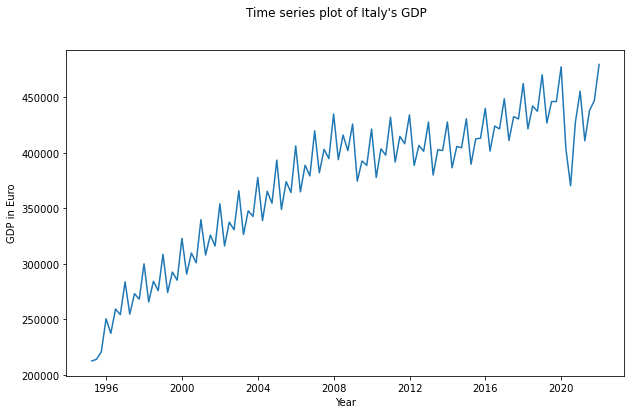

In [2]:
plt.figure(figsize=(10,6))
plt.plot(x)
plt.xlabel('Year')
plt.ylabel('GDP in Euro')
plt.suptitle('Time series plot of Italy\'s GDP')
plt.show()

## 2. Data pre-treatment

In [3]:
# Check if the series is stationary -> we can only model stationary TS

ad_fuller_result1=sm.tsa.stattools.adfuller(x, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
critical_value=0.01
if ad_fuller_result1[1]<critical_value:
    print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
else:
    print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")

ADF Statistic: -1.5996574779712123
p-value: 0.7925663964452637
We cannot reject the null hypothesis of non-stationarity: the TS is not stationary


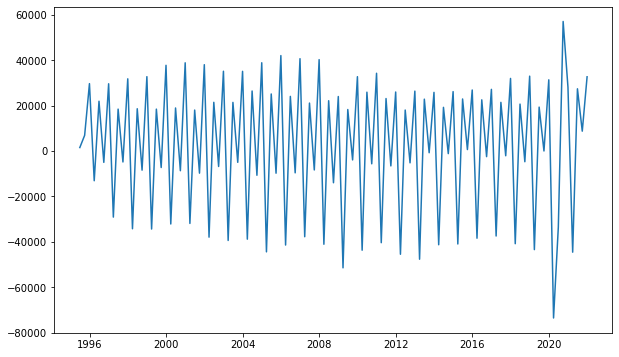

In [4]:
# we take the log-difference and re-apply the ADF test on the new TS

diffx=x.diff()
diffx=diffx.dropna()
plt.figure(figsize=(10,6))
plt.plot(diffx)

In [5]:
ad_fuller_result2=sm.tsa.stattools.adfuller(diffx, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')
critical_value=0.01
if ad_fuller_result2[1]<critical_value:
    print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
else:
    print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")

ADF Statistic: -3.8088019975326755
p-value: 0.01612038159569649
We cannot reject the null hypothesis of non-stationarity: the TS is not stationary


Plot the correlograms for ACF and PACF on the first-differenced data to see why we cannot reject the null (at 1% critical value): 

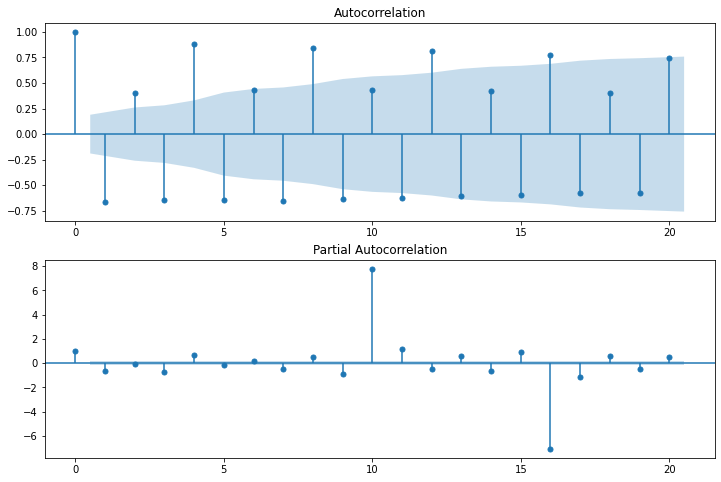

In [6]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(diffx, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(diffx, lags=20, ax=ax2)

warnings.filterwarnings("ignore")

We see that the data show a strong seasonality pattern. To take this into account, we could compute the fourth difference:

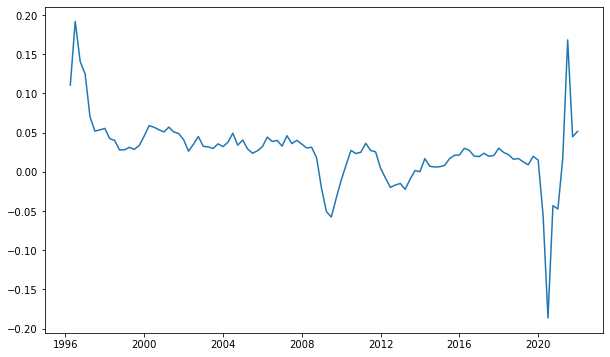

In [7]:
diffx4 = np.log(x)
diffx4 = diffx4.diff(4)
diffx4 = diffx4.dropna()
plt.figure(figsize=(10,6))
plt.plot(diffx4)

In [9]:
ad_fuller_result3=sm.tsa.stattools.adfuller(diffx4, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result3[0]}')
print(f'p-value: {ad_fuller_result3[1]}')
critical_value=0.05
if ad_fuller_result3[1]<critical_value:
    print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
else:
    print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")

ADF Statistic: -3.7708356317522247
p-value: 0.018096247158406097
We can reject the null hypothesis of non-stationarity: the TS is stationary


The series is now stationary (but at 5% risk tolerance level)

## 3. Box-Jerkins #1: identification

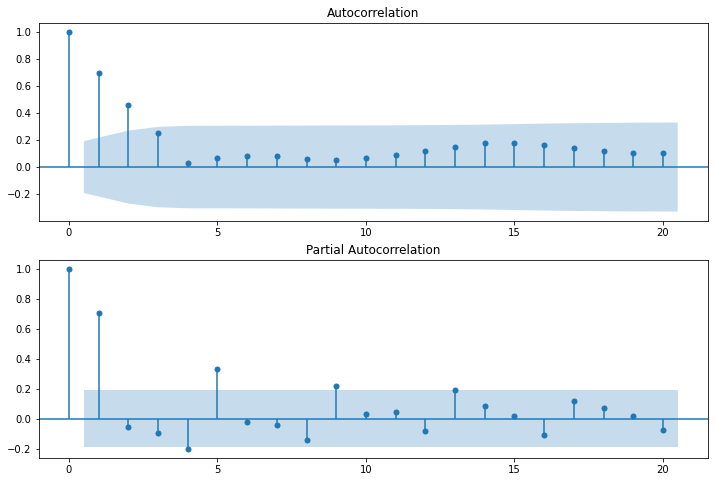

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(diffx4, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(diffx4, lags=20, ax=ax2)

The peak of the PACF after q=1 and the geometric decay of ACF suggest an AR(1) model

In [11]:
from itertools import product
import statsmodels.api as sm
from statsmodels.api import tsa

ar_order = [0, 1, 2]
ma_order = [0, 1, 2]
arma_res = [list(orders) for orders in product(ar_order,ma_order)]

for order in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*order)) 
    try:
        arma_model  = tsa.ARMA(diffx4, order=order).fit(method='mle', disp=-1)
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)
warnings.filterwarnings("ignore")

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2
fitting: ar:1 - ma:0
fitting: ar:1 - ma:1
fitting: ar:1 - ma:2
fitting: ar:2 - ma:0
fitting: ar:2 - ma:1
fitting: ar:2 - ma:2
criterion
    ar_order  ma_order       aic       bic
0         0         0 -0.356550 -0.351262
1         0         1 -0.413566 -0.405633
2         0         2 -0.413365 -0.402787
3         1         0 -0.427530 -0.419597
4         1         1 -0.425549 -0.414971
5         1         2 -0.430537 -0.417316
6         2         0 -0.425553 -0.414975
7         2         1 -0.429150 -0.415928
8         2         2 -0.428171 -0.412304


In [12]:
res.sort_values(by='bic')

,ar_order,ma_order,aic,bic
3,1,0,-0.427530,-0.419597
5,1,2,-0.430537,-0.417316
7,2,1,-0.429150,-0.415928
6,2,0,-0.425553,-0.414975
4,1,1,-0.425549,-0.414971
8,2,2,-0.428171,-0.412304
1,0,1,-0.413566,-0.405633
2,0,2,-0.413365,-0.402787
0,0,0,-0.356550,-0.351262


The best model according to both AIC and BIC criterion is ARMA(2,2). Though, the BIC criterion has a stronger penality term than the AIC. This means that it prefers more parsimonious models than the AIC. We note that the model we proposed before, the AR(1), is the second one preferred by the BIC.

## 4. Box-Jerkins #2: estimation

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(diffx4, order=(2,0,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  104
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 216.777
Date:                Fri, 20 May 2022   AIC                           -425.553
Time:                        09:16:13   BIC                           -414.975
Sample:                    03-31-1996   HQIC                          -421.268
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0290      0.010      2.770      0.006       0.008       0.050
ar.L1          0.7097      0.045     15.920      0.000       0.622       0.797
ar.L2          0.0162      0.076      0.213      0.8

## 5. Box-Jerkins #3: diagnostics

In [14]:
# line plot of residuals
res = pd.DataFrame(model_fit.resid)

In [15]:
ad_fuller_result4=sm.tsa.stattools.adfuller(res, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result4[0]}')
print(f'p-value: {ad_fuller_result4[1]}')
critical_value=0.01
if ad_fuller_result4[1]<critical_value:
    print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
else:
    print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")

ADF Statistic: -8.506828037463324
p-value: 4.838872136330579e-12
We can reject the null hypothesis of non-stationarity: the TS is stationary


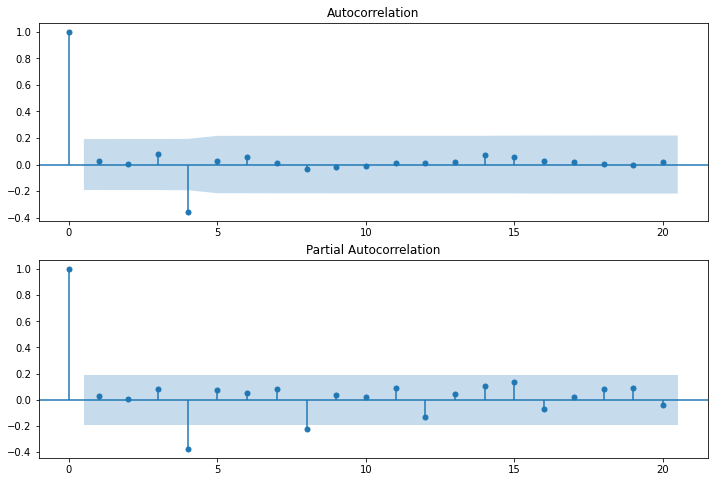

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(res, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(res, lags=20, ax=ax2)

We see that the residuals from the AR(2) model are stationary and display no significant degree of ACF and PACF. Though, there are still some traces of seasonality. To solve this, we could opt for a SARIMAX model (see appendix).

This satisfies our assumptions.

In [17]:
res2=res**2
ad_fuller_result5=sm.tsa.stattools.adfuller(res2, regression='ct', autolag='BIC', store=False, regresults=True)
print(f'ADF Statistic: {ad_fuller_result5[0]}')
print(f'p-value: {ad_fuller_result5[1]}')
critical_value=0.01
if ad_fuller_result5[1]<critical_value:
    print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
else:
    print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")

ADF Statistic: -2.3220089614223096
p-value: 0.4218165110288583
We cannot reject the null hypothesis of non-stationarity: the TS is not stationary


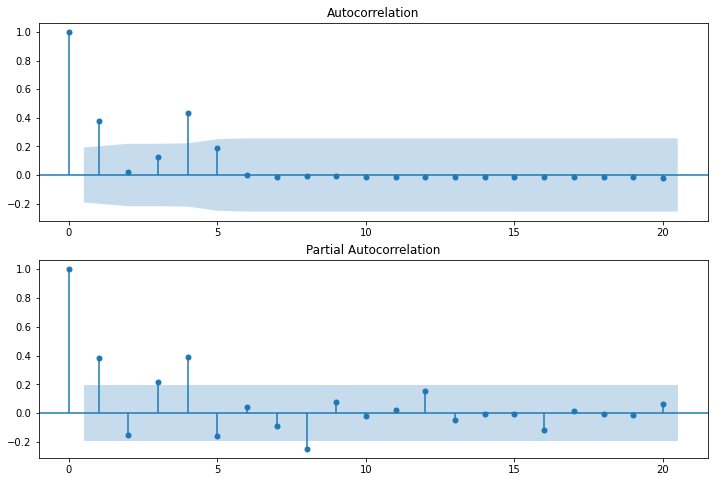

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(res2, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(res2, lags=20, ax=ax2)

We see that the squared residuals display some significant degree of autocorrelation and partial autocorrelation: this means that there is still some unmodeled link. We should thus include a AR-GARCH modelisation.

In [23]:
import statsmodels
statsmodels.stats.diagnostic.het_arch(res2)[1] #p-value from Engle ARCH test

0.0002596707323515088

Engle ARCH test regress squared residuals on their past values, under the null that all the estimated coefficients are zero. In other words, the null is when there is no linear link. Here we reject the null. So there is some significant autocorrelation in squared residuals. This justifies the passage to GARCH model for the variance.

We now apply the GARCH model considering:
 - a constant mean
 - a mean modeled as an AR(2) model

### Constant mean GARCH(1,1) model

In [27]:
from arch import arch_model
am = arch_model(diffx4, p=1, o=0, q=1)
am_fit=am.fit()
am_fit
warnings.filterwarnings("ignore")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1172144.0906756918
Iteration:      2,   Func. Count:     16,   Neg. LLF: -68.91716259066686
Iteration:      3,   Func. Count:     22,   Neg. LLF: 52929801.4213728
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2263433.575345911
Iteration:      5,   Func. Count:     45,   Neg. LLF: -222.73094019763258
Optimization terminated successfully    (Exit mode 0)
            Current function value: -222.73094114339227
            Iterations: 9
            Function evaluations: 45
            Gradient evaluations: 5


### AR(2)-GARCH(1,1) model

In [28]:
am2 = arch_model(diffx4, mean='AR', lags=2)
am2_fit=am2.fit()
am2_fit

Iteration:      1,   Func. Count:      8,   Neg. LLF: 21564632.569172703
Iteration:      2,   Func. Count:     21,   Neg. LLF: 552.150928603103
Iteration:      3,   Func. Count:     34,   Neg. LLF: 329674.63409244735
Iteration:      4,   Func. Count:     44,   Neg. LLF: 5338766.015018942
Iteration:      5,   Func. Count:     56,   Neg. LLF: -267.58682670375697
Optimization terminated successfully    (Exit mode 0)
            Current function value: -267.5868276682014
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 5


                           AR - GARCH Model Results                           
Dep. Variable:                   None   R-squared:                       0.469
Mean Model:                        AR   Adj. R-squared:                  0.459
Vol Model:                      GARCH   Log-Likelihood:                267.587
Distribution:                  Normal   AIC:                          -523.174
Method:            Maximum Likelihood   BIC:                          -507.424
                                        No. Observations:                  102
Date:                Fri, May 20 2022   Df Residuals:                       99
Time:                        09:17:38   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      3.5198e-03  2.472e-03      1.424      0.155 

### Wrapping-up

In [29]:
wrap_up=pd.DataFrame(([model_fit.aic, am_fit.aic, am2_fit.aic], 
                              [model_fit.bic, am_fit.bic, am2_fit.bic]),
                    columns=['AR(2)', 'GARCH(1,1)', 'AR(2)-GARCH(1,1)'],
                    index=['aic', 'bic'])
wrap_up=wrap_up.T
wrap_up.sort_values(by='bic')

,aic,bic
"AR(2)-GARCH(1,1)",-523.173655,-507.423818
"GARCH(1,1)",-437.461882,-426.884319
AR(2),-425.553023,-414.975459


So the preferred model is **AR(2)-GARCH(1,1)**

## 6. Forecasts 

In [30]:
# Q1 out-of-sample forecast
diffx4_Q=diffx4[:-3]
am3_Q1 = arch_model(diffx4_Q, mean='AR', lags=2)
am3_Q1_fit=am3_Q1.fit()
Q1_mean=am3_Q1_fit.forecast(horizon=1).mean['h.1']
Q1_variance=am3_Q1_fit.forecast(horizon=1).variance['h.1']

Q1_pred=Q1_mean.iloc[-1]+np.sqrt(Q1_variance.iloc[-1])
Q1_pred=pd.Series(Q1_pred)

Q1plot=diffx4_Q.append(Q1_pred)
Q1plot.index=diffx4.index[:-2]

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2640838936.295722
Iteration:      2,   Func. Count:     21,   Neg. LLF: 343609.7146244251
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6631159.042086278
Iteration:      4,   Func. Count:     45,   Neg. LLF: 366165.0950993395
Iteration:      5,   Func. Count:     56,   Neg. LLF: 1761.9016865545593
Iteration:      6,   Func. Count:     68,   Neg. LLF: 4439.214606796298
Iteration:      7,   Func. Count:     81,   Neg. LLF: 68532.93498196072
Iteration:      8,   Func. Count:     92,   Neg. LLF: 1977937.1467329839
Iteration:      9,   Func. Count:    105,   Neg. LLF: 54633.40608927771
Iteration:     10,   Func. Count:    117,   Neg. LLF: 2014.3911098685085
Iteration:     11,   Func. Count:    129,   Neg. LLF: 4052114.261564522
Iteration:     12,   Func. Count:    140,   Neg. LLF: 96373.46393677482
Iteration:     13,   Func. Count:    151,   Neg. LLF: 12678.090662446277
Iteration:     14,   Func. Count:    160,   Neg. LLF: 15301.

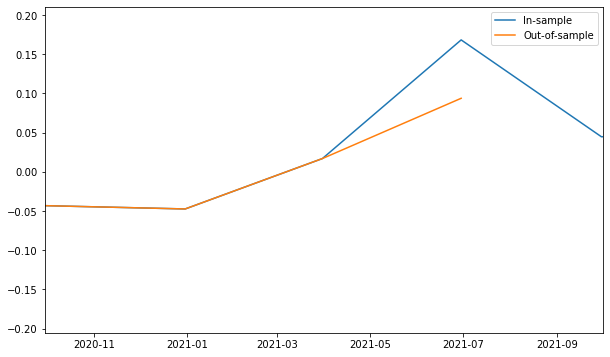

In [31]:
import datetime
plt.figure(figsize=(10,6))
plt.plot(diffx4, label='In-sample')
plt.plot(Q1plot, label='Out-of-sample')
plt.xlim([datetime.date(2020, 9, 30), datetime.date(2021, 10, 1)])
plt.legend()
plt.show()

In [32]:
# Q2 out-of-sample forecast
am3_Q2 = arch_model(diffx4_Q, mean='AR', lags=2)
am3_Q2_fit=am3_Q2.fit()
Q2_mean=am3_Q2_fit.forecast(horizon=2).mean
Q2_variance=am3_Q2_fit.forecast(horizon=2).variance

Q2_pred_1=Q2_mean.iloc[-1][0]+np.sqrt(Q2_variance.iloc[-1][0])
Q2_pred_2=Q2_mean.iloc[-1][1]+np.sqrt(Q2_variance.iloc[-1][1])
Q2_pred=pd.Series([Q2_pred_1, Q2_pred_2])

Q2plot=diffx4_Q.append(Q2_pred)
Q2plot.index=diffx4.index[:-1]

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2640838936.295722
Iteration:      2,   Func. Count:     21,   Neg. LLF: 343609.7146244251
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6631159.042086278
Iteration:      4,   Func. Count:     45,   Neg. LLF: 366165.0950993395
Iteration:      5,   Func. Count:     56,   Neg. LLF: 1761.9016865545593
Iteration:      6,   Func. Count:     68,   Neg. LLF: 4439.214606796298
Iteration:      7,   Func. Count:     81,   Neg. LLF: 68532.93498196072
Iteration:      8,   Func. Count:     92,   Neg. LLF: 1977937.1467329839
Iteration:      9,   Func. Count:    105,   Neg. LLF: 54633.40608927771
Iteration:     10,   Func. Count:    117,   Neg. LLF: 2014.3911098685085
Iteration:     11,   Func. Count:    129,   Neg. LLF: 4052114.261564522
Iteration:     12,   Func. Count:    140,   Neg. LLF: 96373.46393677482
Iteration:     13,   Func. Count:    151,   Neg. LLF: 12678.090662446277
Iteration:     14,   Func. Count:    160,   Neg. LLF: 15301.

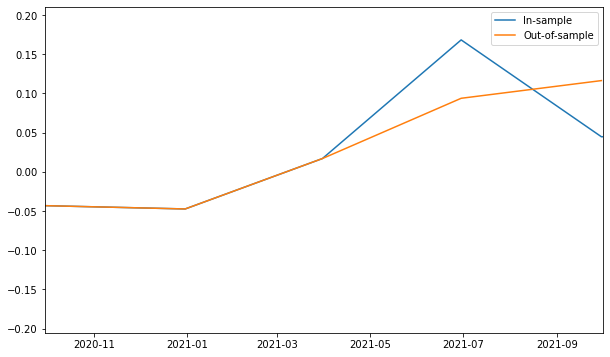

In [33]:
plt.figure(figsize=(10,6))
plt.plot(diffx4, label='In-sample')
plt.plot(Q2plot, label='Out-of-sample')
plt.xlim([datetime.date(2020, 9, 30), datetime.date(2021, 10, 1)])
plt.legend()
plt.show()

In [34]:
# Q3 out-of-sample forecast
am3_Q3 = arch_model(diffx4_Q, mean='AR', lags=2)
am3_Q3_fit=am3_Q3.fit()
Q3_mean=am3_Q3_fit.forecast(horizon=3).mean
Q3_variance=am3_Q3_fit.forecast(horizon=3).variance

Q3_pred_1=Q3_mean.iloc[-1][0]+np.sqrt(Q3_variance.iloc[-1][0])
Q3_pred_2=Q3_mean.iloc[-1][1]+np.sqrt(Q3_variance.iloc[-1][1])
Q3_pred_3=Q3_mean.iloc[-1][2]+np.sqrt(Q3_variance.iloc[-1][2])
Q3_pred=pd.Series([Q3_pred_1, Q3_pred_2, Q3_pred_3])

Q3plot=diffx4_Q.append(Q3_pred)
Q3plot.index=diffx4.index

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2640838936.295722
Iteration:      2,   Func. Count:     21,   Neg. LLF: 343609.7146244251
Iteration:      3,   Func. Count:     32,   Neg. LLF: 6631159.042086278
Iteration:      4,   Func. Count:     45,   Neg. LLF: 366165.0950993395
Iteration:      5,   Func. Count:     56,   Neg. LLF: 1761.9016865545593
Iteration:      6,   Func. Count:     68,   Neg. LLF: 4439.214606796298
Iteration:      7,   Func. Count:     81,   Neg. LLF: 68532.93498196072
Iteration:      8,   Func. Count:     92,   Neg. LLF: 1977937.1467329839
Iteration:      9,   Func. Count:    105,   Neg. LLF: 54633.40608927771
Iteration:     10,   Func. Count:    117,   Neg. LLF: 2014.3911098685085
Iteration:     11,   Func. Count:    129,   Neg. LLF: 4052114.261564522
Iteration:     12,   Func. Count:    140,   Neg. LLF: 96373.46393677482
Iteration:     13,   Func. Count:    151,   Neg. LLF: 12678.090662446277
Iteration:     14,   Func. Count:    160,   Neg. LLF: 15301.

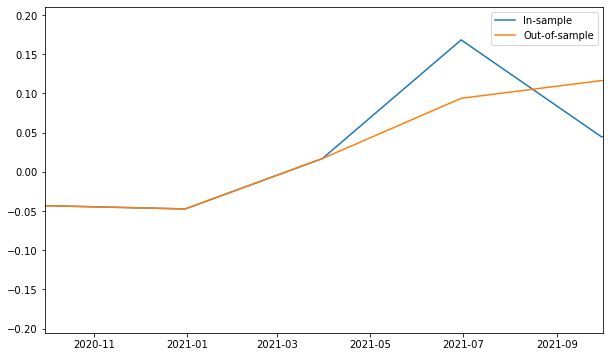

In [35]:
plt.figure(figsize=(10,6))
plt.plot(diffx4, label='In-sample')
plt.plot(Q3plot, label='Out-of-sample')
plt.xlim([datetime.date(2020, 9, 30), datetime.date(2021, 10, 1)])
plt.legend()
plt.show()

## 7. Forecast evaluation

In [36]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(diffx4[-3:], Q3plot[-3:], squared=False)
rmse

0.07208861870553591

## 8. Extra - seasonality 

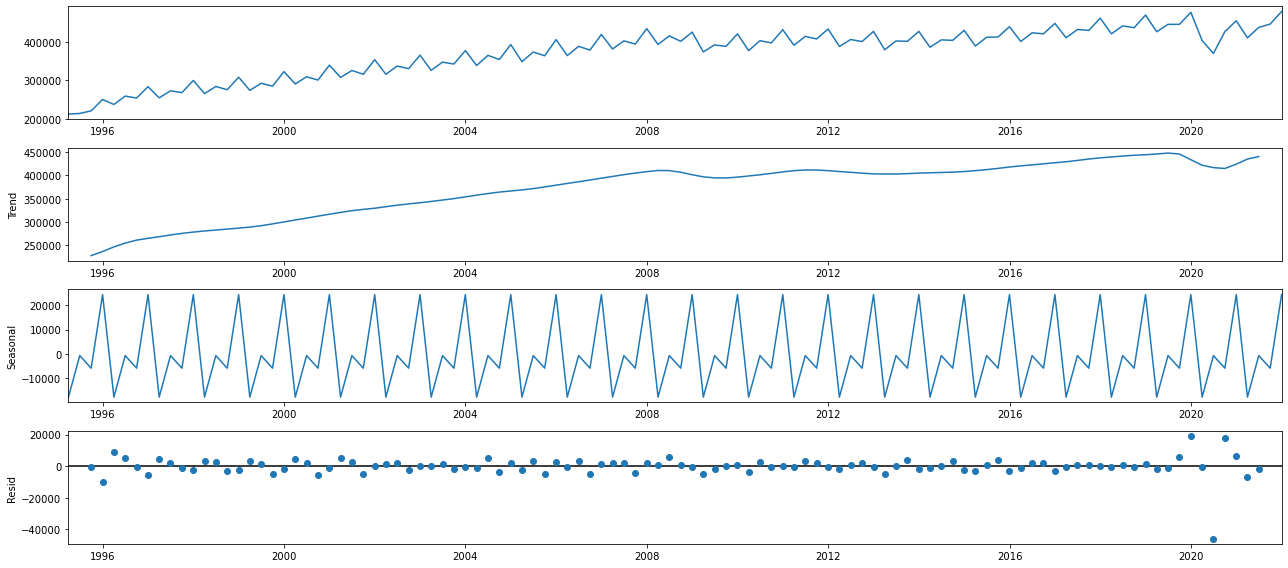

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x, model='additive')
fig = decomposition.plot()
plt.show()

As a concluding remark, we note that the raw GDP TS can be decomposed into a trend component and a seasonal component. There are various ways to model this relationship (like the Hodrick-Prescott filter). Here, we just differenceb by 4 meaning that we tried to neutralise the quaterly impact that various seasonal economic activities have on GDP